## Domainnet Project

-> In this colab, we are going to train a model that will be able to classify 345 different objects.

* As dataset, from TensorFlow datasets domainnet will be used : https://www.tensorflow.org/datasets/catalog/domainnet



## What are we going to cover

* Using TensorFlow Datasets to download and explore the data
* Creating preprocessing function for our data
* Batching & preparing datasets for modelling (making our datasets run fast)
* Creating four modelling callbacks
* Setting up mixed precision training
* Building a feature extraction model
* Fine-tuning the feature extraction model
* Making evaluations on model
* Making predictions with data
* Viewing training results on TensorBoard

## Check for GPU

Check for GPU, in ordeer to use mixed precision with compute compability at least 7.0

In [1]:
# Check Gpu
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-0de1bee5-6f08-0089-85f2-8c24434f9bc0)


In [2]:
import tensorflow as tf

In [3]:
## Get Helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-09-10 12:42:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-10 12:42:30 (117 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import plot_loss_curves, create_tensorboard_callback, compare_historys

## Use TensorFlow Datasets to Download Data

Now we are going to download our dataset and we will become one with the data

In [5]:
import tensorflow_datasets as tfds
dataset_list = tfds.list_builders()

target_dataset = "domainnet"

print(target_dataset in dataset_list)

True


In [6]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name=target_dataset,
                                             split=["train","test"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True
                                             )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/120906 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/domainnet/real/1.0.0.incompleteVZN2A5/domainnet-train.tfrecord*...:   0%| …

Generating test examples...:   0%|          | 0/52041 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/domainnet/real/1.0.0.incompleteVZN2A5/domainnet-test.tfrecord*...:   0%|  …

Dataset domainnet downloaded and prepared to /root/tensorflow_datasets/domainnet/real/1.0.0. Subsequent calls will reuse this data.


In [7]:
# Features of our dataset
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=345),
})

In [8]:
# getting class_names
class_names = ds_info.features["label"].names
class_names

['aircraft_carrier',
 'airplane',
 'alarm_clock',
 'ambulance',
 'angel',
 'animal_migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball_bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday_cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling_fan',
 'cello',
 'cell_phone',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee_cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

## Exploring the Food101 data from TensorFlow Datasets

In [9]:
# take one sample from our train data and examine it
sample = train_data.take(1)
sample = list(sample)

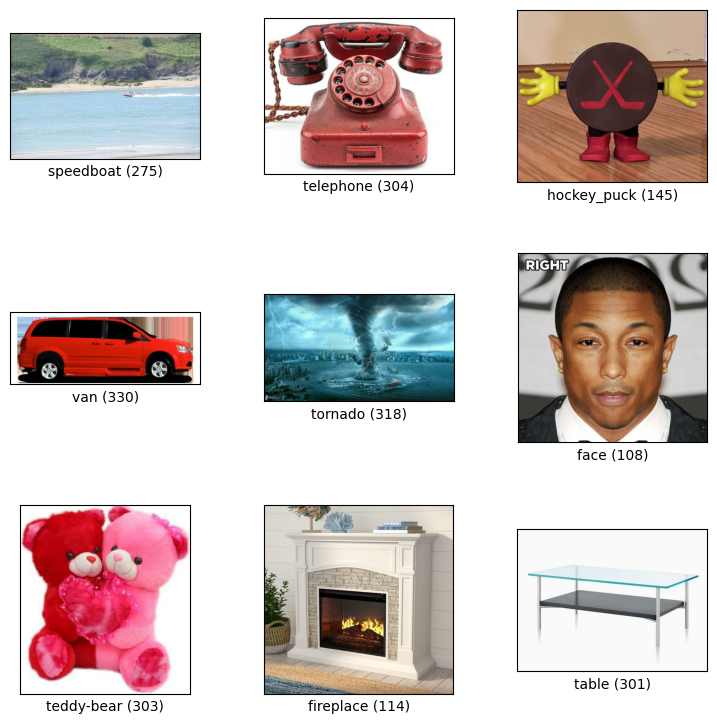

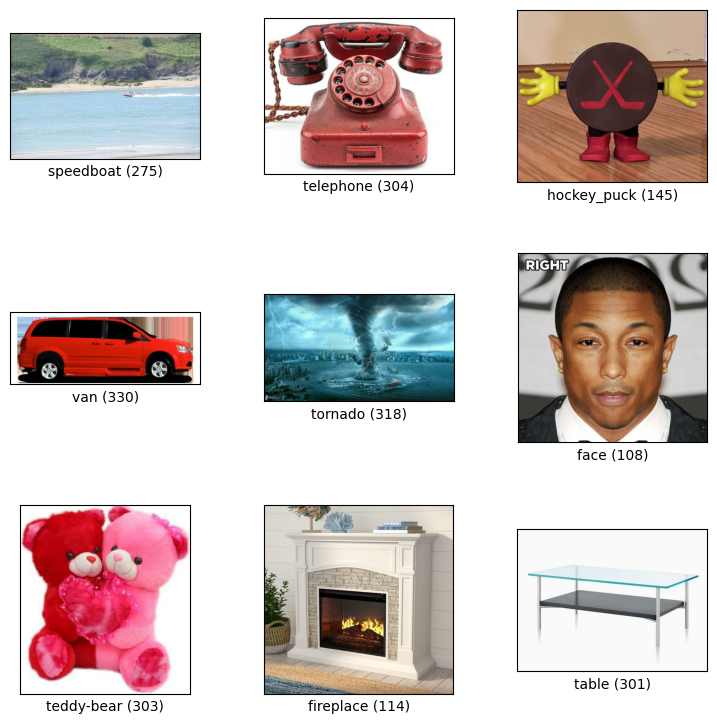

In [10]:
# see examples images
tfds.visualization.show_examples(train_data,ds_info)

## Creating preprocessing function for our data

Let's make a function to preprocess our data and we will pass this function to train data map function

In [11]:
# make a function to preprocessing function
import matplotlib.pyplot as plt

def preprocessing_img(image, label,img_shape = 224,scale=False):

  image = tf.image.resize(image, [img_shape,img_shape])
  image = tf.cast(image,tf.float32)
  if scale:
    image = image / 255
  return image,label

def plot_random_image(train_data = train_data):
  sample = list(train_data.take(1))
  img = sample[0][0]
  label = sample[0][1]
  plt.imshow(img)
  plt.title(class_names[label.numpy()])
  plt.axis(False)


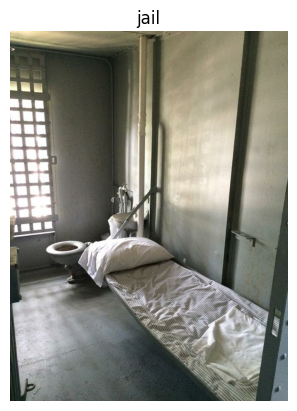

In [12]:
plot_random_image()

In [13]:
# let's preprocess an image
img = sample[0][0]
label = sample[0][1]

preprocessed_img = preprocessing_img(img,label)[0]

img, preprocessed_img

(<tf.Tensor: shape=(320, 366, 3), dtype=uint8, numpy=
 array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [ 70, 175, 181],
         [ 69, 177, 189],
         [ 64, 176, 188]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [ 99, 197, 200],
         [102, 205, 210],
         [103, 208, 214]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [ 64, 150, 141],
         [ 80, 169, 163],
         [ 91, 182, 175]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255,

Our preprocessing functions work wery well now batch and prefetch the data to be trained on fast

## Batch & prepare datasets

In [14]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func = preprocessing_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(map_func=preprocessing_img,num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)


In [15]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks

for future extraction model we will use :

* Tensorbard callback
* ModelCheckPoint callback

for fine tuning model we will use :

* Tensorbard callback
* ModelCheckPoint callback
* EarlyStopping callback
* ReduceLROnPlateau callback

In [16]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "domain_net_future_extraction_model.ckpt"# saving weights requires ".ckpt" extension

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved

## Setup mixed precision training

In [17]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

In [18]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

We have done everything to be able to build the model

In [19]:
from tensorflow.keras import layers
input_shape = (224,224,3)
# Create the base model
base_model = tf.keras.applications.EfficientNetB7(include_top=False)
base_model.trainable = False

# Create the functional model
inputs = layers.Input(shape=input_shape,name="Input_layer")
x = base_model(inputs,training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax",dtype = tf.float32,name = "softmax_float32")(x)
model = tf.keras.Model(inputs,outputs)

258076736/258076736 [==============================] - 12s 0us/step


In [20]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb7 (Functional  (None, None, None, 2560   64097687  
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 2560)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 dense (Dense)               (None, 345)               883545    
                                                                 
 softmax_float32 (Activatio  (None, 345)               0         
 n)                                                          

## Checking layer dtype policies (are we using mixed precision?)

In [22]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

Input_layer True float32 <Policy "float32">
efficientnetb7 False float32 <Policy "mixed_float16">
global_average_pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [23]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block1b_dwconv False float32 <Polic

## Fit the feature extraction model

In [24]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

In [25]:
# Fit the model with callbacks
domainnet_feature_extract = model.fit(train_data,
                                      epochs=3,
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=int(0.15 * len(test_data)),
                                      callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "domainnet_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/domainnet_feature_extract/20230910-130441
Epoch 1/3
3779/3779 [==============================] - 811s 206ms/step - loss: 1.2044 - accuracy: 0.7353 - val_loss: 0.9730 - val_accuracy: 0.7669
Epoch 2/3
3779/3779 [==============================] - 769s 202ms/step - loss: 0.7091 - accuracy: 0.8200 - val_loss: 0.9646 - val_accuracy: 0.7663
Epoch 3/3
3779/3779 [==============================] - 776s 204ms/step - loss: 0.5419 - accuracy: 0.8577 - val_loss: 0.9726 - val_accuracy: 0.7754


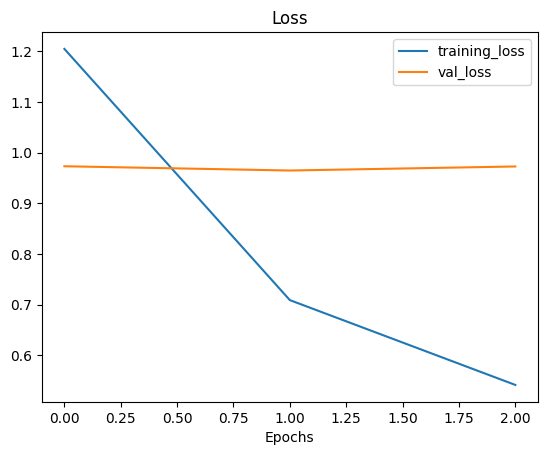

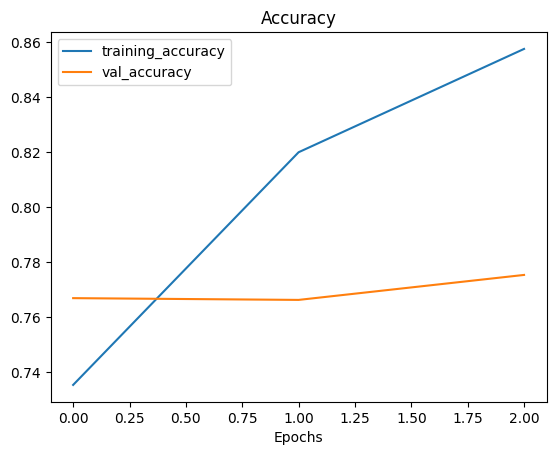

In [26]:
plot_loss_curves(domainnet_feature_extract)

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
# let's evaluate our model
domainnet_future_extraction_results = model.evaluate(test_data)

1627/1627 [==============================] - 298s 183ms/step - loss: 0.9611 - accuracy: 0.7788


In [28]:
# let enjoy our model by making prediction
# Let's make a function to orediction  # improved upon helper functions
def pred_and_plot(model,filename, real_name="" ,class_names = class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename,scale=False)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img/255)
  if real_name == pred_class:
    plt.title(f"Prediction True: {pred_class} ", color="green")
  else:
    plt.title(f"Prediction False: {pred_class}", color="red")
  plt.axis(False);

  # Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224,scale=False):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into specified shape
  (img_shape,img_shape,color_channels=3).

  Args:
    filename (str) : path to target image
    img_shape (int) : height/width dimension of the target image size
    scale (bool) : Scale pixel values from 0-255 to 0-1 or not

  Returns
    Image tensor of shape (img_shape,img_shape,3)
  """
   # Read in the image
  img = tf.io.read_file(filename=filename)

  # Decode image into a tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img,[img_shape,img_shape])

  # Scale? Yes/No
  if scale:
    # rescale the image (get all values betweem 0 & 1)
    return img/255.
  else:
    return img # don't need to rescale images for EfficientNet models in TensorFlow


In [29]:
class_names

['aircraft_carrier',
 'airplane',
 'alarm_clock',
 'ambulance',
 'angel',
 'animal_migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball_bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday_cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling_fan',
 'cello',
 'cell_phone',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee_cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [30]:
# let'S make some predictions

1/1 [==============================] - 6s 6s/step


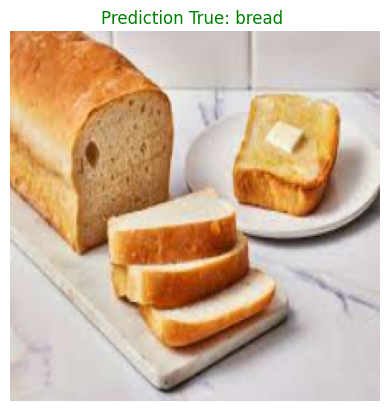

In [33]:
pred_and_plot(model,"/content/drive/MyDrive/Domainnet_data_samples/bread.jpg",real_name="bread")

1/1 [==============================] - 0s 40ms/step


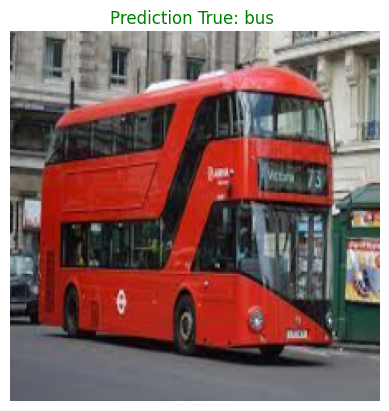

In [34]:
pred_and_plot(model,"/content/drive/MyDrive/Domainnet_data_samples/bus.jpg",real_name="bus")

1/1 [==============================] - 0s 68ms/step


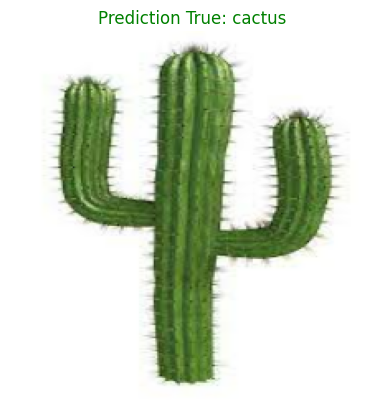

In [35]:
pred_and_plot(model,"/content/drive/MyDrive/Domainnet_data_samples/cactus.jpg",real_name="cactus")

1/1 [==============================] - 0s 41ms/step


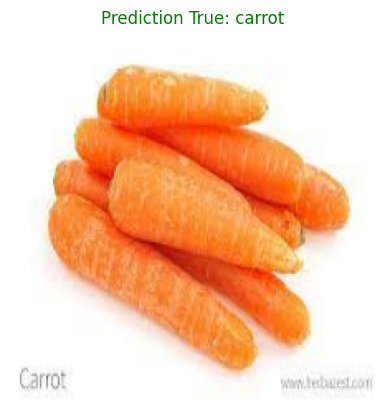

In [36]:
pred_and_plot(model,"/content/drive/MyDrive/Domainnet_data_samples/carrot.jpg",real_name="carrot")

1/1 [==============================] - 0s 47ms/step


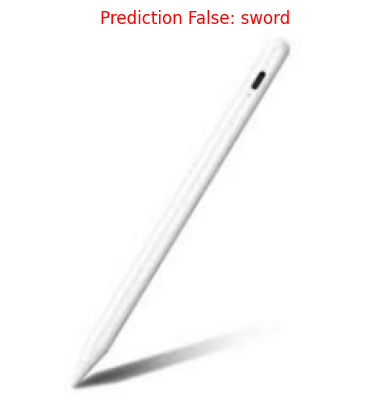

In [37]:
pred_and_plot(model,"/content/drive/MyDrive/Domainnet_data_samples/pencil.jpg",real_name="pencil")

1/1 [==============================] - 0s 60ms/step


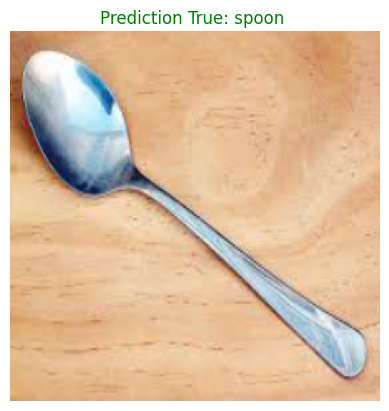

In [38]:
pred_and_plot(model,"/content/drive/MyDrive/Domainnet_data_samples/spoon.jpg",real_name="spoon")

In [39]:
class_names

['aircraft_carrier',
 'airplane',
 'alarm_clock',
 'ambulance',
 'angel',
 'animal_migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball_bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday_cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling_fan',
 'cello',
 'cell_phone',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee_cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

1/1 [==============================] - 0s 46ms/step


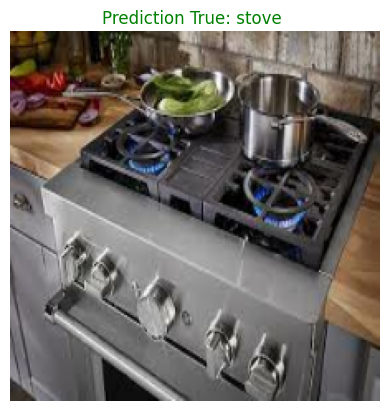

In [40]:
pred_and_plot(model,"/content/drive/MyDrive/Domainnet_data_samples/stove.jpg",real_name="stove")

1/1 [==============================] - 0s 58ms/step


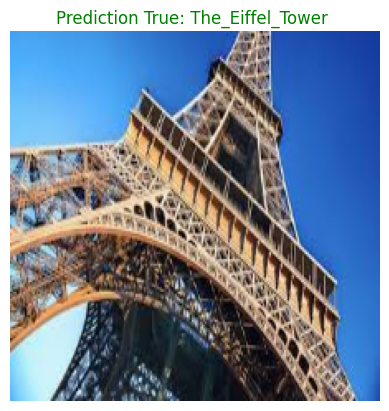

In [41]:
pred_and_plot(model,"/content/drive/MyDrive/Domainnet_data_samples/eiffel.jpg",real_name="The_Eiffel_Tower")

1/1 [==============================] - 0s 42ms/step


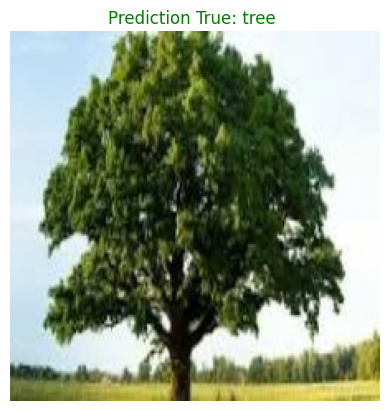

In [42]:
pred_and_plot(model,"/content/drive/MyDrive/Domainnet_data_samples/tree.jpg",real_name="tree")

1/1 [==============================] - 0s 69ms/step


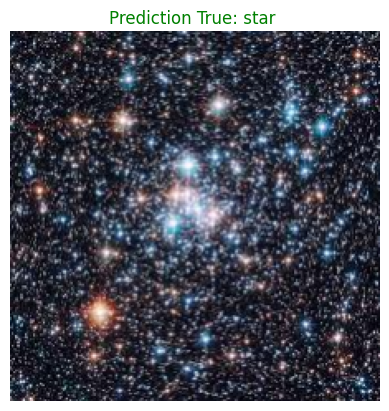

In [43]:
pred_and_plot(model,"/content/drive/MyDrive/Domainnet_data_samples/star.jpg",real_name="star")

1/1 [==============================] - 0s 43ms/step


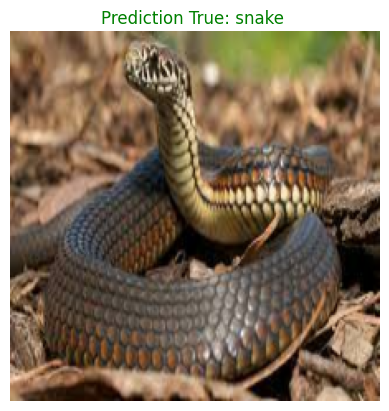

In [44]:
pred_and_plot(model,"/content/drive/MyDrive/Domainnet_data_samples/snake.jpg","snake")

In [45]:
class_names

['aircraft_carrier',
 'airplane',
 'alarm_clock',
 'ambulance',
 'angel',
 'animal_migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball_bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday_cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling_fan',
 'cello',
 'cell_phone',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee_cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

1/1 [==============================] - 0s 41ms/step


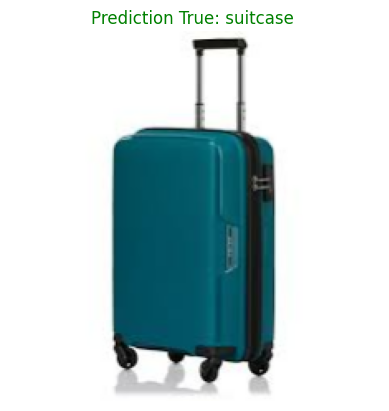

In [46]:
pred_and_plot(model,"/content/drive/MyDrive/Domainnet_data_samples/suitcase.jpg","suitcase")

1/1 [==============================] - 0s 41ms/step


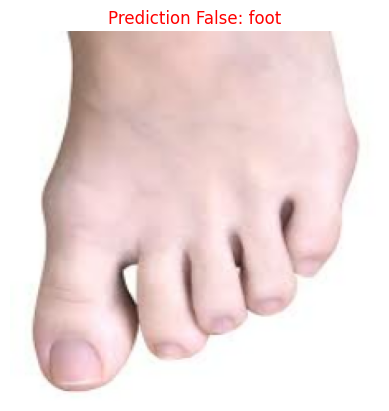

In [47]:
pred_and_plot(model,"/content/drive/MyDrive/Domainnet_data_samples/toe.jpg","toe")

1/1 [==============================] - 0s 74ms/step


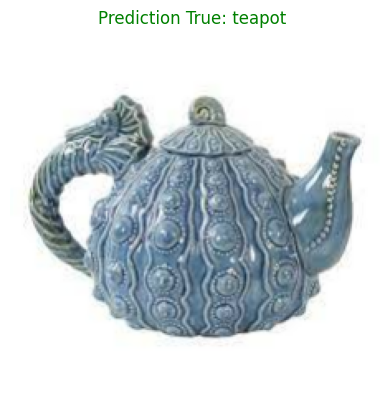

In [48]:
pred_and_plot(model,"/content/drive/MyDrive/Domainnet_data_samples/teapot.jpg","teapot")

In [49]:
class_names

['aircraft_carrier',
 'airplane',
 'alarm_clock',
 'ambulance',
 'angel',
 'animal_migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball_bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday_cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling_fan',
 'cello',
 'cell_phone',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee_cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

1/1 [==============================] - 0s 118ms/step


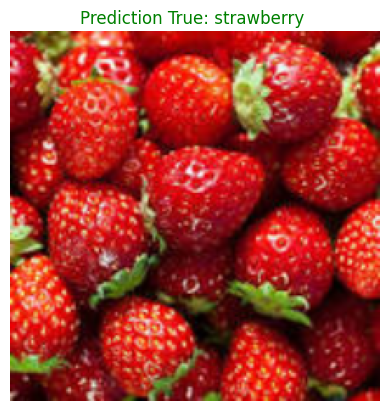

In [50]:
pred_and_plot(model,"/content/drive/MyDrive/Domainnet_data_samples/strawberry.jpg","strawberry")

1/1 [==============================] - 0s 80ms/step


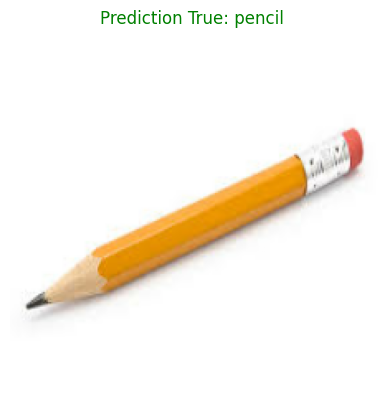

In [51]:
pred_and_plot(model,"/content/drive/MyDrive/Domainnet_data_samples/pencil2.jpg","pencil")

1/1 [==============================] - 0s 181ms/step


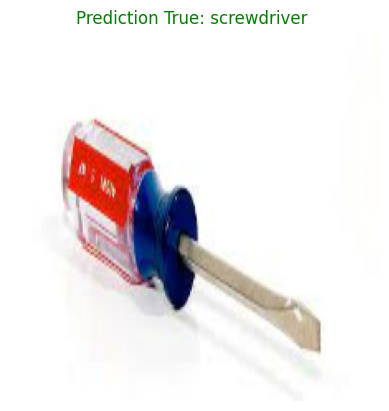

In [52]:
pred_and_plot(model,"/content/drive/MyDrive/Domainnet_data_samples/skrewdriver.jpg","screwdriver")

1/1 [==============================] - 0s 41ms/step


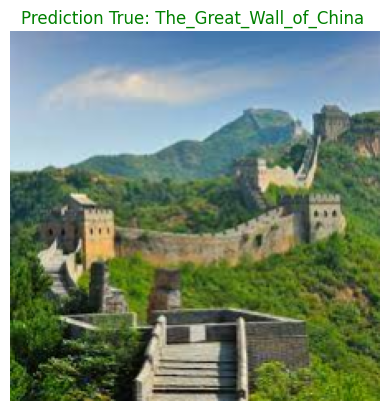

In [53]:
pred_and_plot(model,"/content/drive/MyDrive/Domainnet_data_samples/great_wall.jpg","The_Great_Wall_of_China")

1/1 [==============================] - 0s 43ms/step


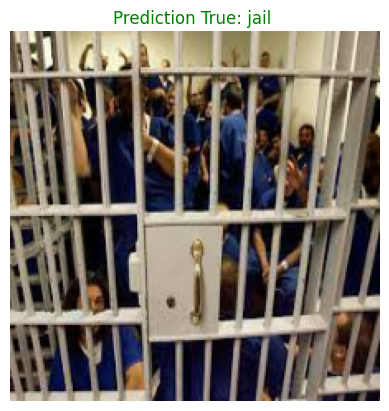

In [54]:
pred_and_plot(model,"/content/drive/MyDrive/Domainnet_data_samples/jail.jpg","jail")

1/1 [==============================] - 0s 62ms/step


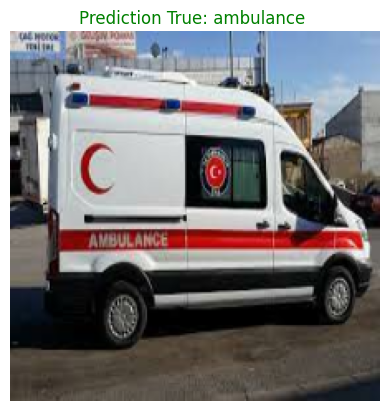

In [55]:
pred_and_plot(model,"/content/drive/MyDrive/Domainnet_data_samples/ambulance.jpg","ambulance")

1/1 [==============================] - 0s 62ms/step


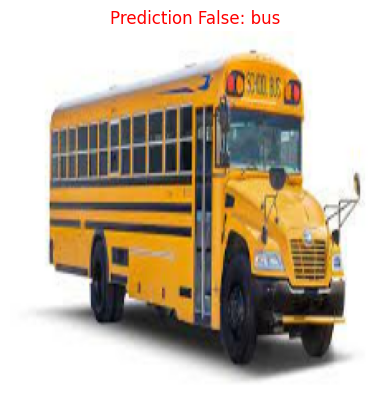

In [56]:
pred_and_plot(model,"/content/drive/MyDrive/Domainnet_data_samples/school_bus.jpg","school_bus")

1/1 [==============================] - 0s 43ms/step


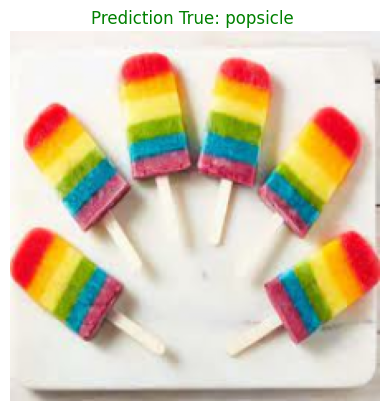

In [57]:
pred_and_plot(model,"/content/drive/MyDrive/Domainnet_data_samples/popsicle.jpg","popsicle")

1/1 [==============================] - 0s 43ms/step


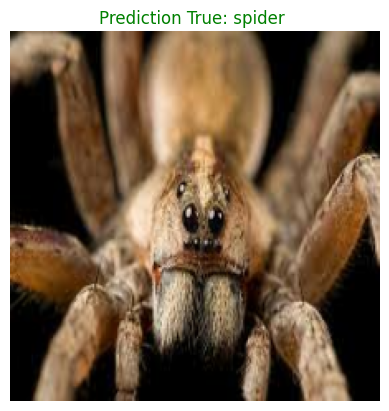

In [58]:
pred_and_plot(model,"/content/drive/MyDrive/Domainnet_data_samples/spider.jpg","spider")

1/1 [==============================] - 0s 47ms/step


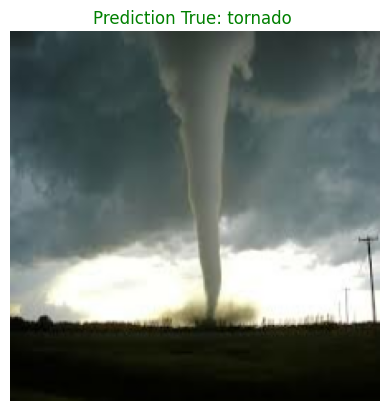

In [59]:
pred_and_plot(model,"/content/drive/MyDrive/Domainnet_data_samples/tornado.jpg","tornado")

1/1 [==============================] - 0s 42ms/step


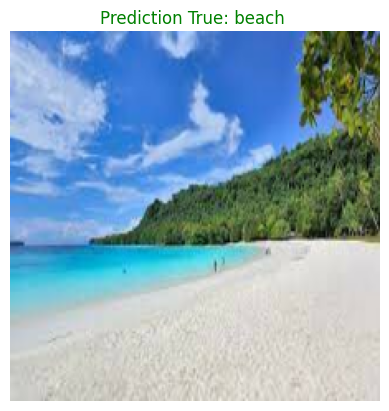

In [60]:
pred_and_plot(model,"/content/drive/MyDrive/Domainnet_data_samples/beach.jpg","beach")

1/1 [==============================] - 0s 42ms/step


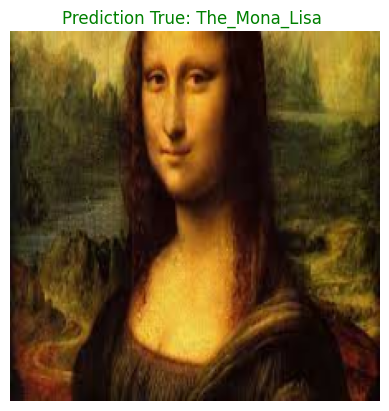

In [61]:
pred_and_plot(model,"/content/drive/MyDrive/Domainnet_data_samples/monalisa.jpg","The_Mona_Lisa")

WAAOOOOWWWWW!!!!!! Our model excellent in estimating although it has to estimate in 365 different class

That is amazing!!!!!

In [62]:
# Let's save our amazing model
model.save("/content/drive/MyDrive/Tensorflow_Machine_Learning/Saved_Models/DomainNet_future_extractor")

## Implementing fine-tuning

In [64]:
# Let's control base model
for layer in base_model.layers:
  print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block1c_dwconv False
block1c_bn False
block1c_activation False
block1c_se_squeeze False
block1c_se_reshape False
block1c_se_reduce False
block1c_se_expand False
block1c_se_excite False
block1c_project_conv False
block1c_project_bn False
block1c_drop False
block1c_add False
block1d_dwconv False
block1d_bn False
block1d_activation False
block1d_se_s

In [66]:
len(base_model.layers[794:814])


20

In [74]:
# Let's make last 20 layer trainable
base_model.trainable = True

In [76]:
# Check again for base_model layers
for layer in base_model.layers[:794]:
  layer.trainable = False

In [77]:
# Let's control base model
for layer in base_model.layers:
  print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block1c_dwconv False
block1c_bn False
block1c_activation False
block1c_se_squeeze False
block1c_se_reshape False
block1c_se_reduce False
block1c_se_expand False
block1c_se_excite False
block1c_project_conv False
block1c_project_bn False
block1c_drop False
block1c_add False
block1d_dwconv False
block1d_bn False
block1d_activation False
block1d_se_s

## Prepare 4 callbacks

1. Tensorboard
2. ModelCheckpoint
3. EarlyStopping
4. ReduceLROnPlateau

In [78]:
# we will create tensorboard callback via helper function (create_tensorboard) while fitting the model

# Create modelcheckpoint callback
checkpoint_path = "/content/drive/MyDrive/Tensorflow_Machine_Learning/Saved_Models/domainnet_fine_tuning_modelcheckpoint"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                      monitor="val_loss",
                                                      save_best_only = True,
                                                      save_weights_only=True,
                                                      )

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience = 4,
                                                  )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                factor=0.2,
                                                patience=3,
                                                verbose=0,
                                                min_lr = 1e-7
                                                )


## Compile the model


In [85]:
# Compile the changed model (because whenever a change is made, we need to recompile the model)
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.0001), # when we implement fine-tuning we need to lower the learning rate
              metrics=["accuracy"]
              )

## Fit the model

In [86]:
# fit the model
fine_tuning_history = model.fit(train_data,
                                epochs=100, # beacuse it will already stop without being 100
                                validation_data = test_data,
                                validation_steps = int(0.15 * len(test_data)),
                                steps_per_epoch = len(train_data),
                                callbacks = [create_tensorboard_callback(dir_name="/content/training_logs",
                                                                experiment_name = "domainnet_fine_tuning"),
                                              model_checkpoint,early_stopping,reduce_lr
                                             ]


                                )

Saving TensorBoard log files to: /content/training_logs/domainnet_fine_tuning/20230910-145637
Epoch 1/100
3779/3779 [==============================] - 862s 219ms/step - loss: 0.3548 - accuracy: 0.9042 - val_loss: 0.8885 - val_accuracy: 0.7912 - lr: 1.0000e-04
Epoch 2/100
3779/3779 [==============================] - 814s 215ms/step - loss: 0.1861 - accuracy: 0.9491 - val_loss: 0.9772 - val_accuracy: 0.7874 - lr: 1.0000e-04
Epoch 3/100
3779/3779 [==============================] - 816s 215ms/step - loss: 0.0834 - accuracy: 0.9772 - val_loss: 1.1399 - val_accuracy: 0.7837 - lr: 1.0000e-04
Epoch 4/100
3779/3779 [==============================] - 853s 225ms/step - loss: 0.0485 - accuracy: 0.9865 - val_loss: 1.2306 - val_accuracy: 0.7883 - lr: 1.0000e-04
Epoch 5/100
3779/3779 [==============================] - 856s 225ms/step - loss: 0.0180 - accuracy: 0.9962 - val_loss: 1.3743 - val_accuracy: 0.7924 - lr: 2.0000e-05


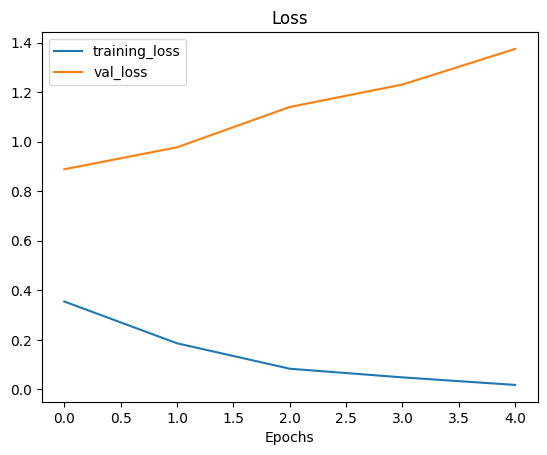

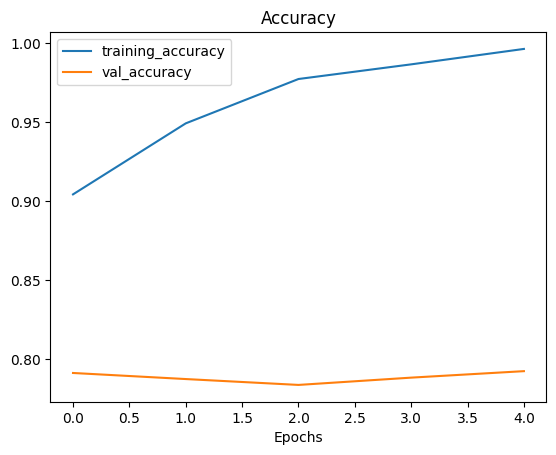

In [87]:
plot_loss_curves(fine_tuning_history)

In [88]:
# Let's save our fine_tuning model
model.save("/content/drive/MyDrive/Tensorflow_Machine_Learning/Saved_Models/DomainNet_Fine_Tuning")

1/1 [==============================] - 8s 8s/step


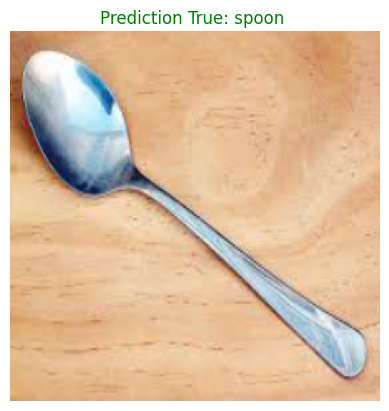

In [89]:
# Make predictions
pred_and_plot(model,"/content/drive/MyDrive/Domainnet_data_samples/spoon.jpg",real_name="spoon")

1/1 [==============================] - 0s 119ms/step


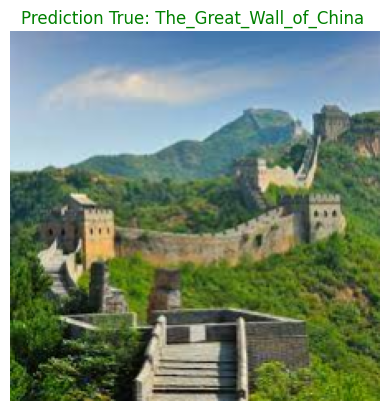

In [91]:
pred_and_plot(model,"/content/drive/MyDrive/Domainnet_data_samples/great_wall.jpg","The_Great_Wall_of_China")